In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [3]:
torch.cuda.set_device(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

torch.cuda.empty_cache()

device

device(type='cuda')

## General diffusion framework

In [4]:
class Diffusion(torch.nn.Module):
    def __init__(self, denoiser, loss=None, T=5):
        super().__init__()
        
        self.denoiser = denoiser
        self.loss = loss
        self.T = T
        
        if self.loss is None:
            self.loss = torch.nn.MSELoss()

    def apply_noise(self, x: torch.Tensor, z: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        return p * x + torch.sqrt(1.0 - p**2) * z

    def get_denoising_loss(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        
        t = torch.rand((batch_size,), device=device) * self.T
        p = torch.exp(-t)
        # p = torch.sqrt(1.0 - torch.rand((batch_size,), device=x.device)**2.0)
        
        z = torch.randn(x.shape, device=x.device)

        x_noisy = self.apply_noise(x, z, p)

        z_pred = self.denoiser(x_noisy, p)

        return self.loss(z_pred, z)

    def sample(self, z: torch.Tensor, p_schedule: torch.Tensor) -> torch.Tensor:
        
        # \overline{\alpha}_t = p_t^2
        # \overline{\alpha}_t = \prod_{s=1}^t \alpha_s
        # \alpha_s = 1 - \beta_s
        # \sigma_t^2 = \beta_t \frac{1 - \overline{\alpha}_{t-1}}{1 - \overline{\alpha}_t}

        overline_alpha = p_schedule**2
        alpha = overline_alpha[1::] / overline_alpha[:-1:]
        beta = 1.0 - alpha
        sigma = torch.sqrt(beta * (1.0 - overline_alpha[:-1:]) / (1.0 - overline_alpha[1::]))

        x = z

        for step in range(1, p_schedule.shape[0]):
            z_pred = self.denoiser(x, p_schedule[-step].repeat(x.shape[0]))
            
            x = (x - z_pred * beta[-step] / torch.sqrt(1.0 - overline_alpha[-step])) / torch.sqrt(alpha[-step])
            x += sigma[-step] * torch.randn(x.shape, device=x.device)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.get_denoising_loss(x)

### MLP Denoiser

In [ ]:
# class MLPDenoiser(torch.nn.Module):
#     def __init__(self, data_dim: int, hidden_dim: int = 1024):
#         super().__init__()

#         self.fc1 = torch.nn.Linear(data_dim + 1, hidden_dim // 8)
#         self.fc2 = torch.nn.Linear(hidden_dim // 8, hidden_dim // 4)
#         self.fc3 = torch.nn.Linear(hidden_dim // 4, hidden_dim // 2)
#         self.fc4 = torch.nn.Linear(hidden_dim // 2, hidden_dim)

#         self.fc5 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
#         self.fc6 = torch.nn.Linear(hidden_dim // 2, hidden_dim // 4)
#         self.fc7 = torch.nn.Linear(hidden_dim // 4, hidden_dim // 8)
#         self.fc8 = torch.nn.Linear(hidden_dim // 8, data_dim)

#         self.act = torch.nn.LeakyReLU()

#         self.skip1 = torch.nn.Linear(data_dim + 1, hidden_dim // 4)
#         self.skip2 = torch.nn.Linear(hidden_dim // 4, hidden_dim // 2)
#         self.skip3 = torch.nn.Linear(hidden_dim // 2, hidden_dim // 2)
#         self.skip4 = torch.nn.Linear(hidden_dim, hidden_dim // 4)
#         self.skip5 = torch.nn.Linear(hidden_dim // 2, hidden_dim // 8)

#     def forward(self, x: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
#         p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
#         x_p = torch.cat([x, p], dim=-1)

#         h1 = self.act(self.fc1(x_p))
#         h2 = self.act(self.fc2(h1) + self.skip1(x_p))
#         h3 = self.act(self.fc3(h2) + self.skip2(h2))
#         h4 = self.act(self.fc4(h3))

#         h5 = self.act(self.fc5(h4) + self.skip3(h3))
#         h6 = self.act(self.fc6(h5) + self.skip4(h4))
#         h7 = self.act(self.fc7(h6) + self.skip5(h5))
#         out = self.fc8(h7)

#         return out

class MLPDenoiser(torch.nn.Module):
    def __init__(self, data_dim: int, hidden_dim: int=300):
        super().__init__()

        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(data_dim + 1, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, data_dim),
        )

    def forward(self, x: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        p = p.reshape((p.shape[0],) + (1,) * (len(x.shape) - 1))
        x_p = torch.cat([x, p], dim=-1)

        return self.MLP(x_p)

In [265]:
def draw_loss(losses):
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Train loss over time")
    plt.show()

In [266]:
def train(
    model,
    optimizer,
    scheduler,
    train_dataloader,
    n_epochs,
    draw_every=1000
):
    step = 0
    losses = []
    
    for epoch in trange(n_epochs):
        for batch in train_dataloader:
            if isinstance(batch, list):
                batch = batch[0]
            
            optimizer.zero_grad()
            
            loss = model(batch.to(device))
            loss.backward()
            
            optimizer.step()
            
            losses.append(loss.item())
            
            if step % draw_every == 0:
                clear_output(wait=True)
                draw_loss(losses)
                tqdm.write(f"Epoch [{epoch+1}/{n_epochs}], Step [{step}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            
            step += 1
            
        scheduler.step()

### 2D test

In [38]:
n_samples = 1000

with torch.no_grad():
    train_x_tensor = torch.rand((n_samples, 2)) + 4 * (torch.randint(2, size=(n_samples,1)) - 0.5) - 0.5
    test_x_tensor  = torch.zeros((n_samples, 2)) + 4 * (torch.randint(2, size=(n_samples,1)) - 0.5) - 0.5
    
    train_x_tensor /= torch.std(train_x_tensor)
    test_x_tensor  /= torch.std(test_x_tensor)

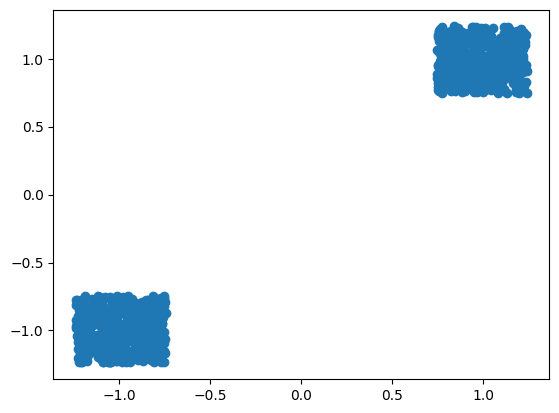

In [39]:
plt.scatter(train_x_tensor[:,0].numpy(), train_x_tensor[:,1].numpy())

In [40]:
train_dataset = TensorDataset(train_x_tensor)
test_dataset = TensorDataset(test_x_tensor)

In [41]:
train_dataloader = DataLoader(train_x_tensor, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_x_tensor, batch_size=512, shuffle=False)

In [42]:
model = Diffusion(
    MLPDenoiser(2)
).to(device)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

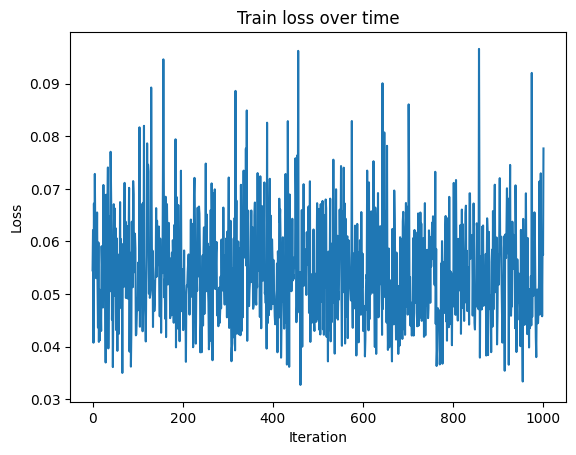

 51%|█████▏    | 514/1000 [00:10<00:04, 99.57it/s] 

Epoch [501/1000], Step [1000/2], Loss: 0.0777


100%|██████████| 1000/1000 [00:21<00:00, 45.89it/s]


In [45]:
train(model, optimizer, train_dataloader, 1000)

In [46]:
z = torch.randn((500, 2), device=device)
# p_schedule = torch.linspace(1.0, 0.01, 100, device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)

In [47]:
with torch.no_grad():
    sampled = model.sample(z, p_schedule)

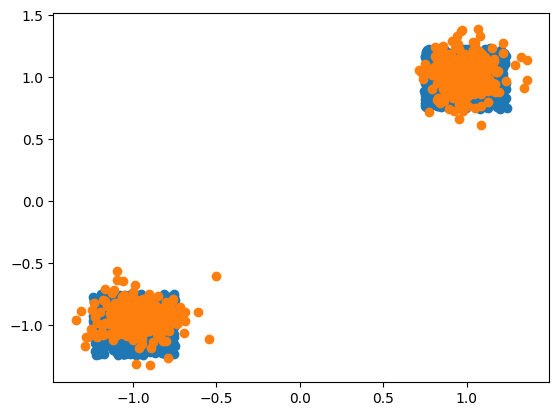

In [48]:
plt.scatter(train_x_tensor[:,0].numpy(), train_x_tensor[:,1].numpy())
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,1].cpu().numpy())

# MI

In [362]:
def create_nd_correlated_data(n_samples, n_dim, r=0.7):
    n_half = n_dim // 2
    mean = torch.zeros(n_dim)
    
    cov = torch.eye(n_dim)
    
    for i in range(n_dim):
        cov[i, n_dim - i - 1] = r

    mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = mvn.sample((n_samples,))
    
    A = dep_data[:, :n_half]
    B = dep_data[:, n_half:]
    
    indep_data = torch.cat([A, B[torch.randperm(n_samples)]], dim=1)
    
    return dep_data, indep_data, cov

In [364]:
def random_covariance_matrix(n):
    A = torch.randn(n, n)
    cov = A @ A.T
    d = torch.sqrt(torch.diag(cov))
    cov = cov / (d.unsqueeze(0) * d.unsqueeze(1))
    return cov

def create_randomly_correlated_normal_data(n_samples, n_dim):
    n_half = n_dim // 2
    mean = torch.zeros(n_dim)
    
    cov = random_covariance_matrix(n_dim)

    joint = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    dep_data = joint.sample((n_samples,))
    
    cov_1 = cov[:n_half, :n_half]
    cov_2 = cov[n_half:, n_half:]
    
    marginal_1 = torch.distributions.MultivariateNormal(torch.zeros(n_half), covariance_matrix=cov_1)
    marginal_2 = torch.distributions.MultivariateNormal(torch.zeros(n_half), covariance_matrix=cov_2)
    
    A = marginal_1.sample((n_samples,))
    B = marginal_2.sample((n_samples,))
    
    indep_data = torch.cat([A, B], dim=1)
    
    return dep_data, indep_data, cov    

def MI_multivariate_normal(cov):
    n_dim = cov.shape[1]
    n_half = n_dim // 2
    cov_1 = cov[:n_half, :n_half]
    cov_2 = cov[n_half:, n_half:]
    det_cov_1 = torch.abs(torch.linalg.det(cov_1))
    det_cov_2 = torch.abs(torch.linalg.det(cov_2))
    det_cov = torch.abs(torch.linalg.det(cov))
    return torch.log(det_cov_1 * det_cov_2 / det_cov) / 2

In [365]:
dep_data, indep_data, cov = create_nd_correlated_data(n_samples, n_dim=50, r=0.7)
# dep_data, indep_data, cov = create_randomly_correlated_normal_data(n_samples, n_dim=6)
MI_multivariate_normal(cov)

tensor(8.4168)

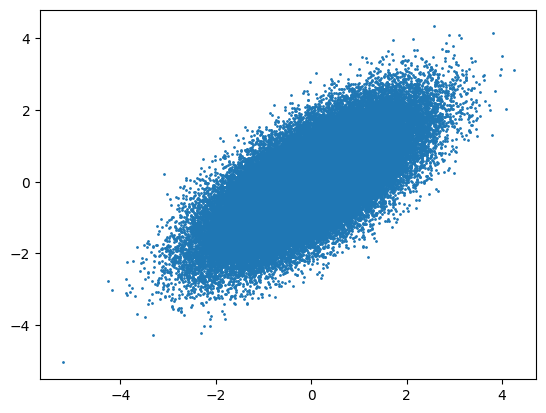

In [366]:
plt.scatter(dep_data[:, 0], dep_data[:, 49], s=1)

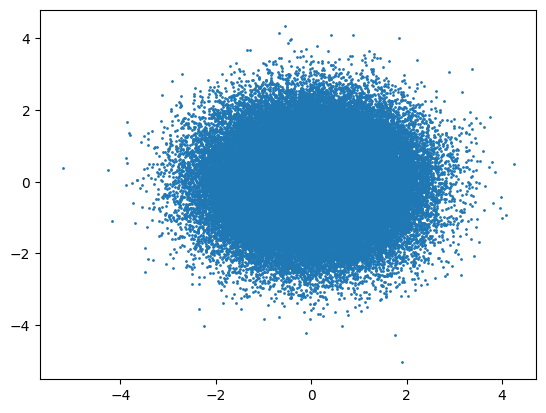

In [367]:
plt.scatter(indep_data[:, 0], indep_data[:, 49], s=1)

In [368]:
dep_train_dataset = TensorDataset(dep_data)
indep_train_dataset = TensorDataset(indep_data)

dep_train_dataloader = DataLoader(dep_train_dataset, batch_size=256, shuffle=True)
indep_train_dataloader = DataLoader(indep_train_dataset, batch_size=256, shuffle=False)

In [373]:
num_epochs = 100

In [374]:
model_AB = Diffusion(MLPDenoiser(50)).to(device)
model_A_B = Diffusion(MLPDenoiser(50)).to(device)

In [375]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer_AB = torch.optim.Adam(model_AB.parameters(), lr=1e-3)
optimizer_A_B = torch.optim.Adam(model_A_B.parameters(), lr=1e-3)

scheduler_AB = CosineAnnealingLR(optimizer_AB, T_max=num_epochs)
scheduler_A_B = CosineAnnealingLR(optimizer_A_B, T_max=num_epochs)

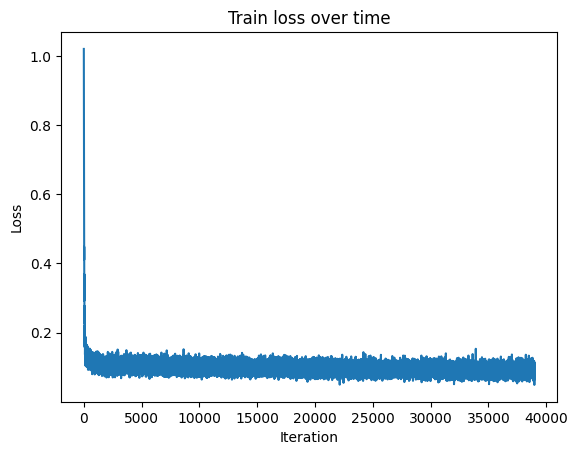

 99%|█████████▉| 99/100 [06:42<00:03,  3.36s/it]

Epoch [100/100], Step [39000/391], Loss: 0.0805


100%|██████████| 100/100 [06:43<00:00,  4.03s/it]


In [376]:
train(model_AB, optimizer_AB, scheduler_AB, dep_train_dataloader, num_epochs, draw_every=100)

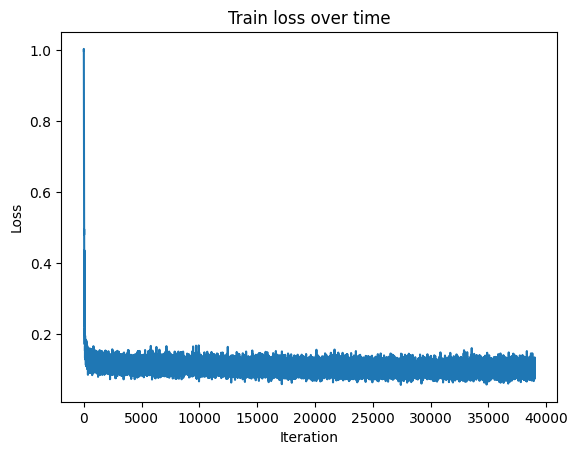

 99%|█████████▉| 99/100 [06:42<00:03,  3.68s/it]

Epoch [100/100], Step [39000/391], Loss: 0.1261


100%|██████████| 100/100 [06:42<00:00,  4.03s/it]


In [377]:
train(model_A_B, optimizer_A_B, scheduler_A_B, indep_train_dataloader, num_epochs, draw_every=100)

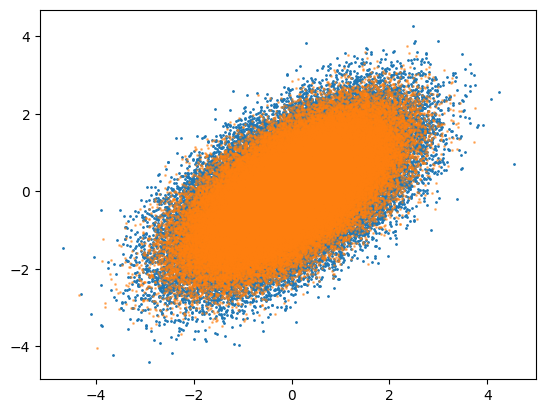

In [344]:
z = torch.randn((100_000, 6), device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)
# p_schedule = 1.0 - torch.linspace(0.0, 0.99, 100, device=device)

with torch.no_grad():
    sampled = model_AB.sample(z, p_schedule)
    
plt.scatter(dep_data[:,0].numpy(), dep_data[:,4].numpy(), s=1)
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,4].cpu().numpy(), alpha=0.5, s=1)

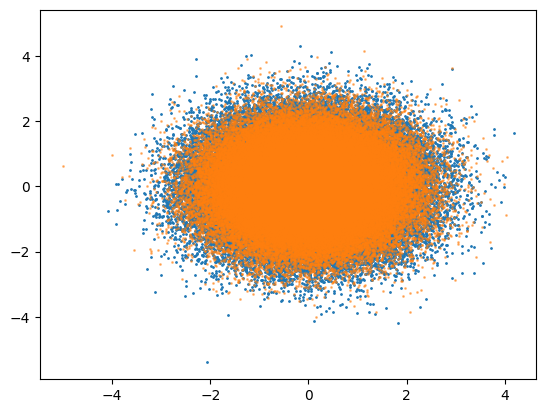

In [317]:
z = torch.randn((100_000, 20), device=device)
p_schedule = torch.sqrt(1.0 - torch.linspace(0.0, 0.99, 100, device=device)**2.0)
# p_schedule = 1.0 - torch.linspace(0.0, 0.99, 100, device=device)

with torch.no_grad():
    sampled = model_A_B.sample(z, p_schedule)
    
plt.scatter(indep_data[:,0].numpy(), indep_data[:,15].numpy(), s=1)
plt.scatter(sampled[:,0].cpu().numpy(), sampled[:,15].cpu().numpy(), alpha=0.5, s=1)

In [378]:
def score_func(model, X_t, t):
    p = torch.exp(-t)
    X_t = X_t.to(device)
    p = p.to(device)
    
    denom = torch.sqrt(1 - p ** 2)
    score = -model.denoiser(X_t, p).detach() / denom
    return score

In [258]:
def estimate_MI(X, num_iters=300_000, T=5):
    I = []
    
    idx = np.random.randint(0, len(X), num_iters)
    ts = torch.rand((num_iters, 1), device=device) * T
    zs = torch.randn(size=(num_iters, 1, X.shape[1])).to(device)
    
    for i in tqdm(range(num_iters)):
        AB = X[idx[i]].unsqueeze(0)
        AB = AB.to(device)
        t = ts[i, :]
        z = zs[i, :, :]

        X_t = torch.exp(-t) * AB + torch.sqrt(1 - torch.exp(-2 * t)) * z
        
        score_AB = score_func(model_AB, X_t, t).cpu()
        score_A_B = score_func(model_A_B, X_t, t).cpu()
        
        I.append(T * ((score_AB - score_A_B) ** 2).sum() / 2)
        
    return np.mean(I)

In [379]:
# Works better than one above

def estimate_MI_steps(X, dt=0.01, T=5, batch_size=100_000):
    
    t_range = np.arange(2 * dt, T, step=dt)
    average_errors = []
    
    for i in trange(len(t_range) - 1):
        t, dt = torch.tensor(t_range[i]), t_range[i + 1] - t_range[i]
        
        squared_error = 0
        
        idx = np.random.randint(0, len(dep_data), batch_size)
        
        AB = dep_data[idx]
        z = torch.randn(size=(1, dep_data.shape[1]))
        X_t = torch.exp(-t) * AB + torch.sqrt(1 - torch.exp(-2 * t)) * z
        
        t = t * torch.ones((batch_size, 1))
        
        score_AB = score_func(model_AB, X_t, t).cpu()
        score_A_B = score_func(model_A_B, X_t, t).cpu()

        squared_error += torch.square(score_AB - score_A_B).sum()
        
        err = squared_error / batch_size
        average_errors.append(err.item())
        
    return average_errors, np.sum(average_errors) * dt

In [348]:
estimate_MI(dep_data, num_iters=100_000)

  0%|          | 41/100000 [00:00<04:07, 403.87it/s]

100%|██████████| 100000/100000 [03:12<00:00, 518.74it/s]


1.2344961

100%|██████████| 498/498 [01:35<00:00,  5.19it/s]


8.333998407164453


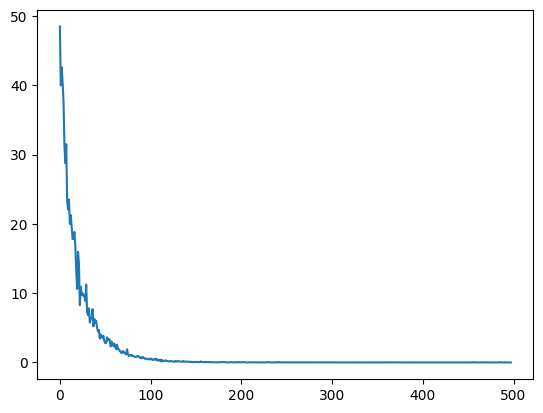

In [380]:
average_errors, MI = estimate_MI_steps(dep_data, batch_size=100_000, dt=0.01)
print(MI)
plt.plot(average_errors)
plt.show()

In [325]:
"ground truth:", -1/2 * np.log(1 - 0.7 ** 2)

('ground truth:', 0.33667227663188276)